In [22]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Hamiltonian Learning using Baeysian approach
The goal of this notebook is to learn two different Hamiltonians using the baeysian approach. First, we deal with a single qubit Hamitlonian.


In [1]:
#importing all packages
import numpy as np
import scipy as sp
from latex_envs.latex_envs import figcaption
from scipy import integrate as int
import matplotlib.pyplot as plt
from qutip import *
from scipy import linalg

In [2]:
#set latex font
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

## Single Qubit and single frequency
\begin{align}
H=\omega \sigma_z
\end{align}
The goal is to learn the parameter $\omega$ starting from a guess $\omega_{\rm guess}$ with some standard deviation  $\sigma$.

In [417]:
#Hamiltonian parameters
Nqubits=1
ω=0.6
Ham=ω*sigmax()

In [402]:
#Initial state and Measurement basis
ψinit=basis(2,0)
projOp=ket2dm(basis(2,0))

In [423]:
np.random.seed(23) #set seed
precision=10**(-6)
nexp=450
σ=0.3
ωguess=0.9
nprt=30
a=0.98 #liu-west resampler
l=0.5
w=1/nprt
x_i=np.random.normal(ωguess,σ,nprt)
w_i=w*np.ones(nprt)
μ=ωguess
μarr=[]
σarr=[]
μarr.append(np.dot(x_i,w_i))
σarr.append(np.sum(x_i*x_i*w_i)-μarr[0]**2)
σ=σarr[0]
x_i_new=np.zeros(nprt)
for expchoice in range(0,nexp):
    t=1.26/σ
    exp_outcome=qSim(Ham,t,ψinit,projOp)
    for prtchoice in range(0,nprt):
        Hamguess=x_i[prtchoice]*sigmax()
        ψTguess=((-1j*t*Hamguess).expm())*ψinit
        if exp_outcome==1:
            prob_dist=expect(projOp,ψTguess)
        else:
            prob_dist=1-expect(projOp,ψTguess)
        w_i[prtchoice]=w_i[prtchoice]*prob_dist
    w_i=w_i/np.sum(w_i)
    μ=np.dot(x_i,w_i) #center of mass
    Σ=np.sum(w_i*x_i*x_i)-μ**2 #variance
    σ=np.sqrt(Σ)
    if 1/np.dot(w_i,w_i)<nprt*l:
        #print("Resampling!")
        Σprime=(1-a**2)*Σ
        σprime=np.sqrt(Σprime)
        for prtchoice in range(0,nprt):
            xIndx = np.random.choice(np.arange(nprt),p=w_i)
            μprime=a*x_i[xIndx]+(1-a)*μ
            x_i_new[prtchoice]=np.random.normal(μprime,σprime)
        x_i=np.copy(x_i_new)    
        w_i=(1/nprt)*np.ones(nprt)
    μ=np.dot(x_i,w_i) #center of mass
    Σ=np.sum(w_i*x_i*x_i)-μ**2 #variance
    σ=np.sqrt(Σ)
    μarr.append(μ)
    σarr.append(σ)
    if σ/μ<precision:
        print("Process terminated at %g steps"%expchoice)
        break

Process terminated at 109 steps


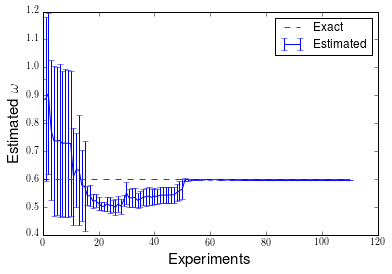

In [432]:
plt.errorbar(range(len(μarr)),μarr,yerr=σarr,label="Estimated")
plt.plot(range(len(μarr)),ω*np.ones(len(μarr)),'--r',label='Exact')
plt.xlabel('Experiments',fontsize=15)
plt.ylabel('Estimated $\\omega$',fontsize=15)
plt.legend()
figcaption('Estimated frequency as a function of experiments.')

## Single Qubit, Multiple parameters
Now, Let us try to estimate,
\begin{align}
H=h_x \sigma_x+h_y \sigma_y+h_z \sigma_z
\end{align}

In [53]:
#Exact Hamiltonian parameters
keylist=['hx','hy','hz']
ham_params_list=[0.4,0.7,0.9]
Op_list=[sigmax(),sigmay(),sigmaz()]
count=0
ham_params={key:ham_params_list[ind] for ind,key in enumerate(keylist)}
Ham=sum(ham_params_list[ind]*Op_list[ind] for ind,key in enumerate(keylist))

In [54]:
#Initial state and Measurement basis
ψinit=rand_ket(2)#basis(2,0) 
projOp=ket2dm(basis(2,0))
projOplist=[ket2dm((basis(2,0)+basis(2,1))/np.sqrt(2)),ket2dm((basis(2,0)+1j*basis(2,1))/np.sqrt(2)),ket2dm(basis(2,0))]

In [56]:
np.random.seed(10) #set seed
precision=10**(-6)
nexp=400
nprt=100
a=0.98 #liu-west resampler
l=0.5
σdict={'hx':0.3,'hy':0.3,'hz':0.3} # stddev of initial distributions
params_guess={'hx':0.5,'hy':0.5,'hz':0.7}

if len(params_guess)!=len(keylist):
    print("Define the correct number of variables in keylist and parmas_guess")
xvec={key:np.random.normal(params_guess[key],σdict[key],nprt) for key in keylist} #generates a dictionary of lists
w=1/nprt #weights initialized
w_i=w*np.ones(nprt)
μdict={key : [] for key in keylist}
σdict={key : [] for key in keylist}
for key in keylist:
    μtemp=np.dot(xvec[key],w_i)
    σtemp=np.sqrt(np.dot(w_i,xvec[key]**2)-μtemp**2)
    μdict[key].append(μtemp) 
    σdict[key].append(σtemp)
σ={key : σdict[key][0] for key in keylist}
μ={key : μdict[key][0] for key in keylist}

resamplecount=0
for expchoice in range(0,nexp):
    print(expchoice, end='\r', flush=True)
    ψinit=rand_ket(2)
    projOp=ket2dm(ψinit)#projOplist[np.random.randint(3)]
    t=optimized_suggestion(xvec,σ['hx'])  
    exp_outcome=qSim(Ham,t,ψinit,projOp)
    for prtchoice in range(0,nprt):
        Hamguess=xvec['hx'][prtchoice]*sigmax()+xvec['hy'][prtchoice]*sigmay()+xvec['hz'][prtchoice]*sigmaz()
        prob_dist=clSim(Hamguess,t,ψinit,projOp,exp_outcome) 
        w_i[prtchoice]=w_i[prtchoice]*prob_dist #Bayesian update
    w_i=w_i/np.sum(w_i)
    if 1/np.dot(w_i,w_i)<nprt*l:
        xvec,w_i=resample(xvec,w_i,keylist,a)
        resamplecount+=1
    μ,σ=meanstd(xvec,w_i,keylist)    
    {key : μdict[key].append(μ[key])   for key in keylist}
    {key : σdict[key].append(σ[key])   for key in keylist}
    #precision test
    σmaxkey=max(σ,key=σ.get) #max std dev
    if np.abs(σ[σmaxkey]/μ[σmaxkey])<precision:
        print("Process terminated at %g steps"%expchoice)
        break
print("Resampling count=%g"%resamplecount)

Resampling count=12


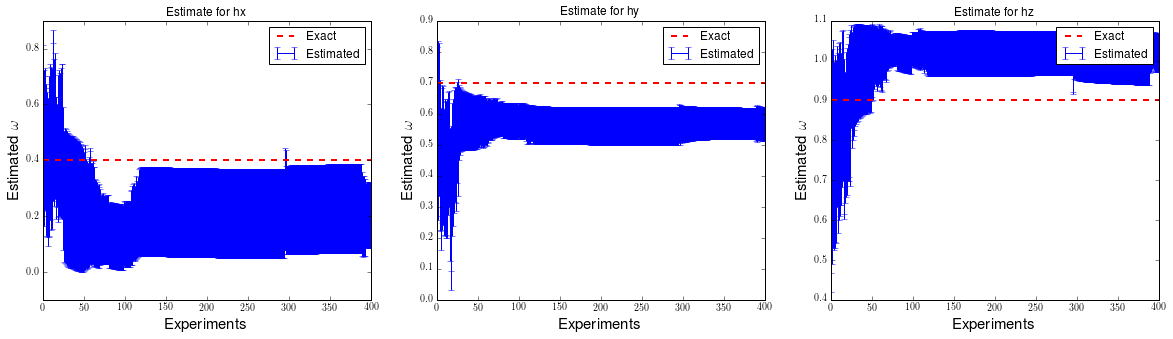

In [57]:
fig=plt.figure(figsize=(20,5))
count=0
for key in keylist:
    count+=1
    plt.subplot(1,len(keylist),count)
    plt.errorbar(range(len(μdict[key])),μdict[key],yerr=σdict[key],label="Estimated")
    plt.plot(range(len(μdict[key])),ham_params[key]*np.ones(len(μdict[key])),'--r',linewidth=2,label='Exact')
    plt.xlabel('Experiments',fontsize=15)
    plt.ylabel('Estimated $\\omega$',fontsize=15)
    plt.legend()
    plt.title('Estimate for %s'%key)

In [544]:
key='hx'
print('Estimate for %s'%key)

Estimate for hx


In [644]:
type(xvec)

dict

## Single Qubit including dephasing
In this section,we include the effect of $T_2$ time dephasing as done by Granade et al, in Ref. NJP, 14,103013. The output probabilities for a Hamiltonians given by $H=\omega \sigma_z$, has the following output probabilites,
\begin{align}
P(0|\omega ;t)&=\exp\left(-\frac{t}{T_2}\right)\cos^2(\omega t)+\frac{1-\exp\left(-\frac{t}{T_2}\right)}{2}\\
P(1|\omega ;t)&=1-P(0|\omega ;t)
\end{align}

In [58]:
#Exact Hamiltonian parameters
keylist=['hz','T2']
ham_params_list=[0.6,200*np.pi]
Op_list=[sigmaz()]
count=0
ham_params={key:ham_params_list[ind] for ind,key in enumerate(keylist)}
Ham,T2=Ham_def_dephased(ham_params_list,Op_list,keylist)
#sum(ham_params_list[ind]*Op_list[ind] for ind,key in enumerate(keylist))

In [59]:
#Initial state and Measurement basis
ψinit=(basis(2,0)+basis(2,1))/np.sqrt(2) 
projOp=ket2dm(ψinit)
projOplist=[ket2dm((basis(2,0)+basis(2,1))/np.sqrt(2)),ket2dm((basis(2,0)+1j*basis(2,1))/np.sqrt(2)),ket2dm(basis(2,0))]

In [66]:
#Parameters for SMC
precision=10**(-6)
nexp=200
nprt=100
a=0.98 #liu-west resampler
l=0.5
params_guess={'hz':0.5,'T2':180*np.pi}
σ_guess={'hz':0.3/np.sqrt(3),'T2':100*np.pi/np.sqrt(3)} # stddev of initial distributions
μdict={key : [] for key in keylist}
σdict={key : [] for key in keylist}

In [69]:

np.random.seed(10) #set seed
if len(params_guess)!=len(keylist):
    print("Define the correct number of variables in keylist and parmas_guess")
xvec={key:np.random.uniform(max(0,params_guess[key]-np.sqrt(3)*σ_guess[key]),params_guess[key]+np.sqrt(3)*σ_guess[key],nprt) for key in keylist}
#xvec={key:np.random.normal(params_guess[key],σ_guess[key],nprt) for key in keylist} #generates a dictionary of lists
w=1/nprt #weights initialized
w_i=w*np.ones(nprt)
for key in keylist:
    μtemp=np.dot(xvec[key],w_i)
    σtemp=np.sqrt(np.dot(w_i,xvec[key]**2)-μtemp**2)
    μdict[key].append(μtemp) 
    σdict[key].append(σtemp)
    
σ={key : σdict[key][0] for key in keylist}
μ={key : μdict[key][0] for key in keylist}

resamplecount=0
for expchoice in range(0,nexp):
    print(expchoice, end='\r', flush=True)
    #ψinit=rand_ket(2)
    t=random_suggestion(0,200*np.pi)#optimized_suggestion(xvec,σ['hz']) #random_suggestion(0,20*np.pi)  
    exp_outcome=qSim_deph(Ham,t,ψinit,projOp,T2)
    for prtchoice in range(0,nprt):
        xguess=[xvec[key][prtchoice] for key in keylist]
        Hamguess, T2guess=Ham_def_dephased(xguess,Op_list,keylist)
        prob_dist=clSim_deph(Hamguess,t,ψinit,projOp,exp_outcome,T2guess) 
        w_i[prtchoice]=w_i[prtchoice]*prob_dist #Bayesian update
    w_i=w_i/np.sum(w_i)
    #w_i=rmsmallnos(w_i,0)
    if 1/np.dot(w_i,w_i)<nprt*l:
        xvec,w_i=resample(xvec,w_i,keylist,a)
        resamplecount+=1
    μ,σ=meanstd(xvec,w_i,keylist)    
    {key : μdict[key].append(μ[key])   for key in keylist}
    {key : σdict[key].append(σ[key])   for key in keylist}
    #precision test
    σmaxkey=max(σ,key=σ.get) #max std dev
    if np.abs(σ[σmaxkey]/μ[σmaxkey])<precision:
        print("Process terminated at %g steps"%expchoice)
        break
print("Resampling count=%g"%resamplecount)

Resampling count=26


In [41]:
σ

{'T2': 68.81300831994005, 'hz': 0.16498595545850814}

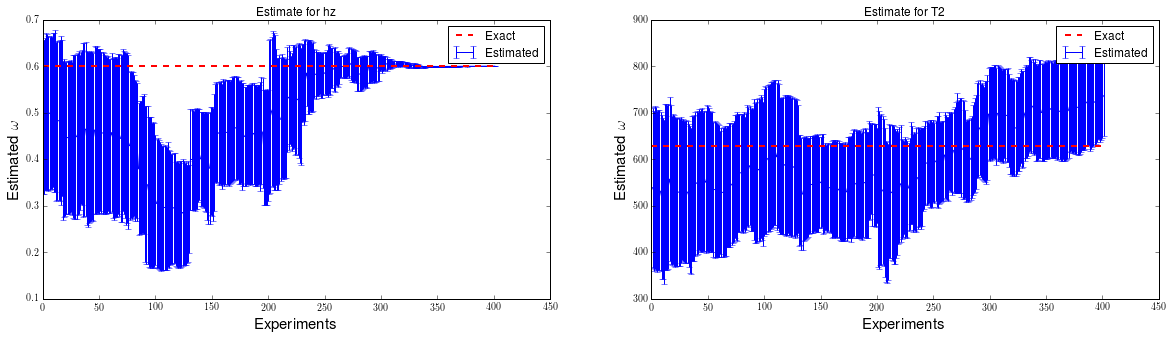

In [70]:
fig=plt.figure(figsize=(20,5))
count=0
for key in keylist:
    count+=1
    plt.subplot(1,len(keylist),count)
    plt.errorbar(range(len(μdict[key])),μdict[key],yerr=σdict[key],label="Estimated")
    plt.plot(range(len(μdict[key])),ham_params[key]*np.ones(len(μdict[key])),'--r',linewidth=2,label='Exact')
    plt.xlabel('Experiments',fontsize=15)
    plt.ylabel('Estimated $\\omega$',fontsize=15)
    plt.legend()
    plt.title('Estimate for %s'%key)

In [242]:
prob_dist

0.06290101554312286

## Identify $T_2$

/home/paraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


Resampling count=0


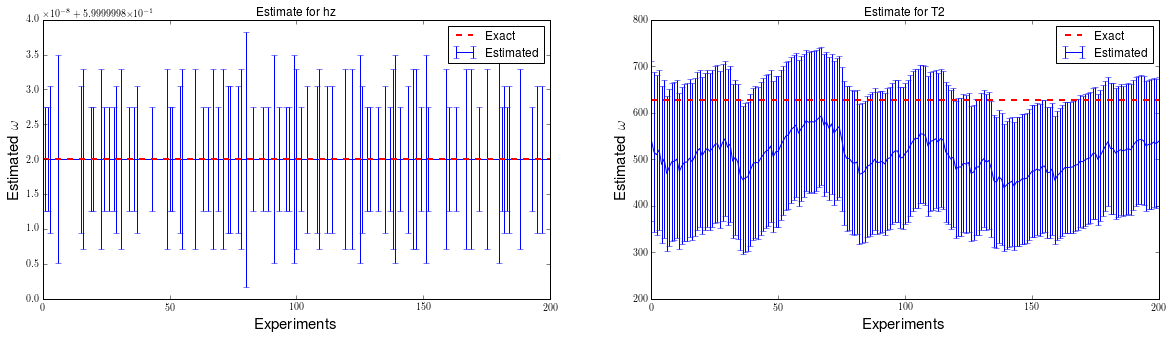

In [73]:
#Exact Hamiltonian parameters
keylist=['hz','T2']
ham_params_list=[0.6,200*np.pi]
Op_list=[sigmaz()]
count=0
ham_params={key:ham_params_list[ind] for ind,key in enumerate(keylist)}
Ham,T2=Ham_def_dephased(ham_params_list,Op_list,keylist)
#sum(ham_params_list[ind]*Op_list[ind] for ind,key in enumerate(keylist))

#Initial state and Measurement basis
ψinit=(basis(2,0)+basis(2,1))/np.sqrt(2) 
projOp=ket2dm(ψinit)
projOplist=[ket2dm((basis(2,0)+basis(2,1))/np.sqrt(2)),ket2dm((basis(2,0)+1j*basis(2,1))/np.sqrt(2)),ket2dm(basis(2,0))]

#Parameters for SMC
precision=10**(-6)
nexp=200
nprt=100
a=0.98 #liu-west resampler
l=0.5
params_guess={'hz':0.6,'T2':180*np.pi}
σ_guess={'hz':0.0/np.sqrt(3),'T2':100*np.pi/np.sqrt(3)} # stddev of initial distributions
μdict={key : [] for key in keylist}
σdict={key : [] for key in keylist}


np.random.seed(10) #set seed
if len(params_guess)!=len(keylist):
    print("Define the correct number of variables in keylist and parmas_guess")
xvec={key:np.random.uniform(max(0,params_guess[key]-np.sqrt(3)*σ_guess[key]),params_guess[key]+np.sqrt(3)*σ_guess[key],nprt) for key in keylist}
#xvec={key:np.random.normal(params_guess[key],σ_guess[key],nprt) for key in keylist} #generates a dictionary of lists
w=1/nprt #weights initialized
w_i=w*np.ones(nprt)
for key in keylist:
    μtemp=np.dot(xvec[key],w_i)
    σtemp=np.sqrt(np.dot(w_i,xvec[key]**2)-μtemp**2)
    μdict[key].append(μtemp) 
    σdict[key].append(σtemp)
    
σ={key : σdict[key][0] for key in keylist}
μ={key : μdict[key][0] for key in keylist}

resamplecount=0
for expchoice in range(0,nexp):
    print(expchoice, end='\r', flush=True)
    #ψinit=rand_ket(2)
    t=random_suggestion(0,200*np.pi)#optimized_suggestion(xvec,σ['hz']) #random_suggestion(0,20*np.pi)  
    exp_outcome=qSim_deph(Ham,t,ψinit,projOp,T2)
    for prtchoice in range(0,nprt):
        xguess=[xvec[key][prtchoice] for key in keylist]
        Hamguess, T2guess=Ham_def_dephased(xguess,Op_list,keylist)
        prob_dist=clSim_deph(Hamguess,t,ψinit,projOp,exp_outcome,T2guess) 
        w_i[prtchoice]=w_i[prtchoice]*prob_dist #Bayesian update
    w_i=w_i/np.sum(w_i)
    #w_i=rmsmallnos(w_i,0)
    if 1/np.dot(w_i,w_i)<nprt*l:
        xvec,w_i=resample(xvec,w_i,keylist,a)
        resamplecount+=1
    μ,σ=meanstd(xvec,w_i,keylist)    
    {key : μdict[key].append(μ[key])   for key in keylist}
    {key : σdict[key].append(σ[key])   for key in keylist}
    #precision test
    σmaxkey=max(σ,key=σ.get) #max std dev
    if np.abs(σ[σmaxkey]/μ[σmaxkey])<precision:
        print("Process terminated at %g steps"%expchoice)
        break
print("Resampling count=%g"%resamplecount)


fig=plt.figure(figsize=(20,5))
count=0
for key in keylist:
    count+=1
    plt.subplot(1,len(keylist),count)
    plt.errorbar(range(len(μdict[key])),μdict[key],yerr=σdict[key],label="Estimated")
    plt.plot(range(len(μdict[key])),ham_params[key]*np.ones(len(μdict[key])),'--r',linewidth=2,label='Exact')
    plt.xlabel('Experiments',fontsize=15)
    plt.ylabel('Estimated $\\omega$',fontsize=15)
    plt.legend()
    plt.title('Estimate for %s'%key)

## Function Definitions 
Listing all the functions defined to be called in the different sections.
\begin{itemize}
\item qSim(Hamiltonian,time,initial state,measured_operator): 
        where Hamiltonian, initial state and measured_operator are all qutip objects
\end{itemize}


In [28]:
#coherent part of evolution
def Ham_def(ham_params_list,Op_list,keylist):
    return sum(ham_params_list[ind]*Op_list[ind] for ind,key in enumerate(keylist))
def Ham_def_dephased(ham_params_list1,Op_list1,keylist):
    #includes T2 time
    keylist1=keylist.copy()
    T2=ham_params_list1[keylist.index('T2')]
    keylist1.remove('T2')
    return sum(ham_params_list1[ind]*Op_list1[ind] for ind,key in enumerate(keylist1)),T2

In [29]:
def qSim(H,t,init,proj):
    u = (-1j*t*H).expm()
    psiT = u*init
    pMeasure = expect(proj,psiT)
    return np.random.binomial(1,pMeasure)

def qSim_deph(H,t,init,proj,T2):
    u = (-1j*t*H).expm()
    psiT = u*init
    pMeasure_coherent = expect(proj,psiT)
    pMeasure_dephased=np.exp(-t/T2)*pMeasure_coherent+(1-np.exp(-t/T2))/2
    return np.random.binomial(1,pMeasure_dephased)

In [30]:
def clSim(H,t,init,proj,exp_outcome):
    ψTguess=((-1j*t*H).expm())*init
    if exp_outcome==1:
        prob_dist=expect(proj,ψTguess)
    else:
        prob_dist=1-expect(proj,ψTguess)
    return prob_dist

def clSim_deph(H,t,init,proj,exp_outcome,T2):
    ψTguess=((-1j*t*H).expm())*init
    if exp_outcome==1:
        prob_dist=expect(proj,ψTguess)
    else:
        prob_dist=1-expect(proj,ψTguess)
    prob_dist_dephased=np.exp(-t/T2)*prob_dist+(1-np.exp(-t/T2))/2
    if prob_dist_dephased<0:
        print("Negative probability")
        print(prob_dist, T2)        
    return prob_dist_dephased

In [42]:
def optimized_suggestion(x_i,σ):
    #Use particle guess heurestic
    #x_i and \sigma are dictionaries with the new variables
    t=1.26/σ#[max(σ,key=σ.get)]
    #t=
    return t

def random_suggestion(lval,hval):
    t=np.random.uniform(low=lval,high=hval)
    return t

In [32]:
def meanstd(xvec,w_i,keylist):
    σ={}
    μ={}
    for key in keylist:
        μtemp=np.dot((xvec[key]),w_i)
        σtemp=np.sqrt(np.dot(w_i,(xvec[key])**2)-μtemp**2)
        μ.update({key : μtemp}) #center of mass
        σ.update({key : σtemp})
    return (μ,σ)

In [33]:
def resample(xvec,w_i,keylist,a):
    #print("Resampling!")
    μ,σ=meanstd(xvec,w_i,keylist)
    σprime={key : np.sqrt((1-a*a))*σ[key] for key in keylist}
    xvec_new={key : np.empty(nprt) for key in keylist}
    for prtchoice in range(0,nprt):
        xIndx = np.random.choice(np.arange(nprt),p=w_i)
        μprime={key : a*xvec[key][xIndx]+(1-a)*μ[key] for key in keylist}
        for key in keylist:
            xvec_new[key][prtchoice]=np.random.uniform(max(0,μprime[key]-np.sqrt(3)*σprime[key]),μprime[key]+np.sqrt(3)*σprime[key]) #np.random.normal(μprime[key],σprime[key])   
    w_i_new=(1/nprt)*np.ones(nprt)
    return (xvec_new,w_i_new)

In [34]:
def rmsmallnos(w_i,lowVal):
    low_values_flags = w_i < lowVal  # Where values are low
    w_i[low_values_flags] = 0
    w_i=w_i/np.sum(w_i)
    return w_i

In [72]:
np.random.uniform(1,1,10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])